In [1]:
import numpy as np
from skimage import io,color,exposure
import cv2 as cv
from scipy.signal import convolve2d
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter
from skimage.exposure import histogram_matching

In [2]:
def make_correction(channel:np.ndarray,mu:float)->np.ndarray:
    channel=channel/255.0
    channel_mean=channel.mean()
    channel_var=channel.var()
    channel_max=channel_mean+mu*channel_var
    channel_min=channel_mean-mu*channel_var
    channel_corrected=255.0*(channel-channel_min)/(channel_max-channel_min)
    channel_corrected=np.clip(channel_corrected,0,255)
    return channel_corrected.astype(np.uint8)

In [3]:
def shrink(x:np.ndarray,eps:float)->float:
    norm=np.linalg.norm(x,ord=2)
    if norm ==0:
        return np.zeros(shape=x.shape)
    ans=x*np.max(norm-eps,0)/norm
    return ans

In [4]:
def get_corrected_image(img:np.ndarray,mu:float)->np.ndarray:
    R,G,B=img[:,:,0],img[:,:,1],img[:,:,2]
    R_corrected,G_corrected,B_corrected=make_correction(R,mu),make_correction(G,mu),make_correction(B,mu)
    corrected_image=np.stack([R_corrected,G_corrected,B_corrected],axis=-1)
    return corrected_image


In [5]:
def RGB2LAB(img:np.ndarray)->tuple[np.ndarray]:
    lab_img=color.rgb2lab(img)
    L,A,B=lab_img[:,:,0],lab_img[:,:,1],lab_img[:,:,2]
    return (L,A,B)

In [6]:
def initialize_RI(L_channel:np.ndarray)->tuple[np.ndarray]:
    height,width=L_channel.shape[0],L_channel.shape[1]
    R=np.zeros(shape=(height,width))
    I0=gaussian_filter(L_channel,sigma=2)
    return (R,I0)

In [7]:
KERNEL_X=np.array([[-1,1]])
KERNEL_Y=np.array([[-1],[1]])

In [8]:
def gradient_x(img:np.ndarray)->np.ndarray:
    kernel_x=np.abs(convolve2d(img,KERNEL_X,mode='same'))
    return np.uint8(kernel_x)

In [9]:
def gradient_y(img:np.ndarray)->np.ndarray:
    kernel_y=np.abs(convolve2d(img,KERNEL_Y,mode='same'))
    return np.uint8(kernel_y)

In [10]:
# delta denotes lambda in original paper we can not use lambda as variable because it is a reserved keyword in python language
def optimizer(R:np.ndarray,I:np.ndarray,I0:np.ndarray,L:np.ndarray,d:np.ndarray,alpha:float=100,beta:float=0.1,gamma:float=1,delta:float=10)->float:
    penalty1=(np.linalg.norm(R*I-L,ord=2))**2
    penalty2=(alpha*(np.linalg.norm(np.vstack((gradient_x(I),gradient_y(I))),ord=2))**2)
    penalty3=(delta*(np.linalg.norm(np.vstack((gradient_x(R),gradient_y(R)))-d,ord=2))**2)
    penalty3=beta*(penalty3+np.linalg.norm(d,ord=1))
    penalty4=gamma*(np.linalg.norm(I-I0,ord=2))**2
    return (penalty1+penalty2+penalty3+penalty4)

In [11]:
def update_d(R:np.ndarray,delta:float=10)->np.ndarray:
    d_x=shrink(gradient_x(R),1.0/2*delta)
    d_y=shrink(gradient_y(R),1.0/2*delta)
    return np.vstack((d_x,d_y))

In [12]:
def denom(D_x:np.ndarray=KERNEL_X,D_y:np.ndarray=KERNEL_Y)->np.ndarray:
    fft_d_x=np.fft.fft(D_x)
    conjugate_fft_d_x=np.conjugate(fft_d_x)
    fft_d_y=np.fft.fft(D_y)
    conjugate_fft_d_y=np.conjugate(fft_d_y)
    return (fft_d_x.dot(conjugate_fft_d_x.T)).squeeze()+(fft_d_y.T.dot(conjugate_fft_d_y)).squeeze()

In [13]:
def update_R(L:np.ndarray,I:np.ndarray,beta:float=0.1,delta:float=10)->np.ndarray:
    numerator=(1+beta*delta)*np.fft.fft(L/I)
    denominator=(np.fft.fft([1])+beta*delta*denom())
    return (np.fft.ifft(numerator/denominator)).real
    

In [14]:
def update_I(I0:np.ndarray,L:np.ndarray,R:np.ndarray,alpha:float=100,gamma:float=1)->np.ndarray:
    numerator=np.fft.fft(gamma*I0+L/R)
    denominator=(np.fft.fft([1+gamma])+alpha*denom())
    return (np.fft.ifft(numerator/denominator)).real

In [15]:
def enhance_R(R:np.ndarray)->np.ndarray:
    clahe=cv.createCLAHE(1,[8,8])
    clahe_result=clahe.apply(R)
    return clahe_result

In [16]:
def LAB2RGB(L:np.ndarray,A:np.ndarray,B:np.ndarray)->np.ndarray:
    h,b=A.shape
    LAB_IMAGE=np.zeros(shape=(h,b,3))
    LAB_IMAGE[:,:,0],LAB_IMAGE[:,:,1],LAB_IMAGE[:,:,2]=L,A,B
    image=color.lab2rgb(LAB_IMAGE)
    return image

In [17]:
def clahe(image, clip_limit, tile_size):
  # Convert the image to float32 and normalize it to [0, 1]
  # image = image.astype(np.float32) / 255.0

  # Get the shape and size of the image
  height, width = image.shape
  image_size = height * width

  # Compute the number of tiles in each dimension
  num_tiles_x = int(np.ceil(width / tile_size))
  num_tiles_y = int(np.ceil(height / tile_size))

  # Pad the image if necessary to make it divisible by the tile size
  pad_x = (num_tiles_x * tile_size) - width
  pad_y = (num_tiles_y * tile_size) - height
  image = np.pad(image, ((0, pad_y), (0, pad_x)), mode="reflect")
 
  # Create an empty array for the output image
  output = np.zeros_like(image)

  # Loop over the tiles
  for i in range(num_tiles_x):
    for j in range(num_tiles_y):
      # Get the coordinates of the current tile
      x1 = i * tile_size
      x2 = (i + 1) * tile_size
      y1 = j * tile_size
      y2 = (j + 1) * tile_size

      # Get the tile data
      tile = image[y1:y2, x1:x2]

      # Compute the histogram and the cumulative distribution function of the tile
      hist, bins = np.histogram(tile.flatten(), bins=100, range=(0, 1))
      cdf = hist.cumsum()
      cdf = cdf / cdf[-1] # Normalize the cdf to [0, 1]

      # Apply the clip limit to the histogram
      clip_value = clip_limit * hist.max()
      excess = hist - clip_value
      excess = excess[excess > 0].sum()

      # Redistribute the excess pixels uniformly
      hist = np.clip(hist, 0, clip_value)
      step = excess / 100
      hist = hist + step

      # Recompute the cdf after clipping
      cdf = hist.cumsum()
      cdf = cdf / cdf[-1]

      # Interpolate the cdf values for the tile pixels
      tile = np.interp(tile.flatten(), bins[:-1], cdf)

      # Reshape the tile and store it in the output image
      tile = tile.reshape((tile_size, tile_size))
      output[y1:y2, x1:x2] = tile

  # Crop the output image to the original size
  output = output[:height, :width]

  # Convert the output image to uint8 and scale it to [0, 255]
  output = (output * 255).astype(np.uint8)

  # Return the output image
  return output


In [18]:
def histogram_specification(v:np.ndarray)->np.ndarray:
    I_atan = np.arctan(v)
    hist, bins = np.histogram(I_atan.flatten(), bins=256, density=True) 
    cdf = hist.cumsum()
    cdf /= cdf[-1]
    t = np.linspace(15,230,230-15)
    st = np.arctan(t-15)
    cdf_desired = st.cumsum()/st.sum() 
    I_enhanced = exposure.equalize_hist(I_atan, cdf_desired)
    return I_enhanced

In [19]:
image=io.imread("../images/test2.jpg")

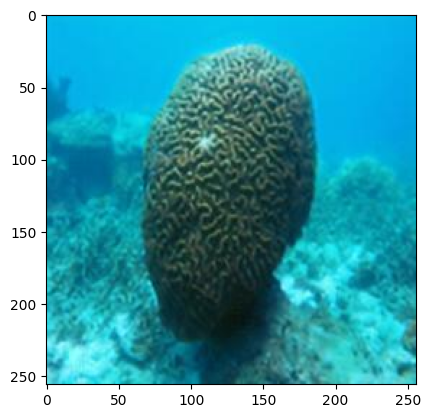

In [20]:
plt.imshow(image)
plt.show()

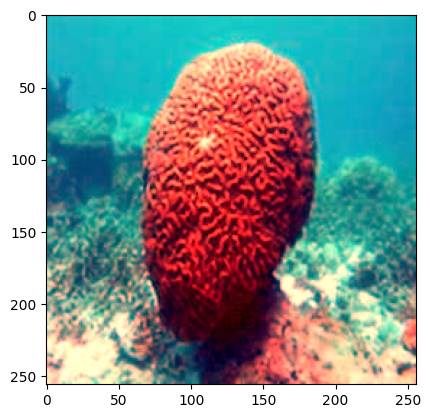

In [21]:
corrected_image=get_corrected_image(image,8)
plt.imshow(corrected_image)
plt.show()

In [22]:
L,A,B=RGB2LAB(corrected_image)

In [23]:
R,Io=initialize_RI(L)

In [24]:
Io.max(),Io.min()

(98.98073543095467, 1.899158667212773)

In [25]:
I=L

In [26]:
I.max(),I.min()

(99.05863290733859, 0.6039260722940583)

In [27]:
R=update_R(L,I)

In [28]:
R.max(),R.min()

(0.2857142857142857, 0.2857142857142857)

In [29]:
I=update_I(Io,L,R)

In [30]:
I=np.maximum(L,I)

In [31]:
I.max(),I.min()

(99.05863290733859, 0.6039260722940583)

In [32]:
R=update_R(L,I)

In [33]:
R.max(),R.min()

(0.2857142857142857, 0.2857142857142857)

In [34]:
I=update_I(Io,L,R)

In [35]:
I.max(),I.min()

(0.7403421106422586, 0.008056761769125398)

In [36]:
I=np.maximum(I,L)

In [37]:
I.max(),I.min()

(99.05863290733859, 0.6039260722940583)

In [38]:
R=update_R(L,I)

In [39]:
R.max(),R.min()

(0.2857142857142857, 0.2857142857142857)

In [40]:
R=R.astype(np.float32)

In [41]:
np.argmax(np.isnan(R))

0

In [42]:
R.max(),R.min()

(0.2857143, 0.2857143)

In [43]:
I_enhanced=histogram_specification(I)

In [44]:
img=LAB2RGB(I,A,B)

In [45]:
I.max(),I.min()

(99.05863290733859, 0.6039260722940583)

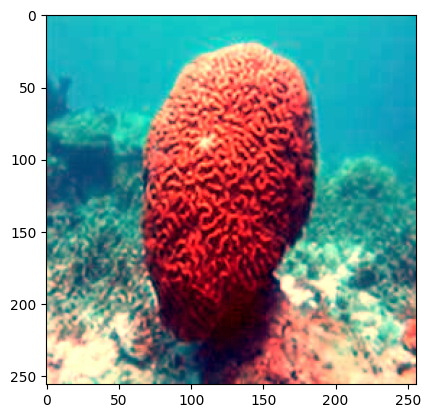

In [46]:
plt.imshow(img)
plt.show()

In [49]:
I_arc_tan=np.arctan(I)
hist_I_tan_arc,_=np.histogram(I_arc_tan,bins=100)
pdf_arc_tan=hist_I_tan_arc/hist_I_tan_arc.sum()

In [50]:
source_hist,_=np.histogram(I,bins=100)
weighted_source_hist=source_hist*pdf_arc_tan
print(weighted_source_hist)

[1.86157227e-03 0.00000000e+00 0.00000000e+00 6.72912598e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 6.01196289e-03 3.54003906e-03 0.00000000e+00
 5.85937500e-03 0.00000000e+00 9.64355469e-03 0.00000000e+00
 0.00000000e+00 7.81250000e-03 0.00000000e+00 1.65252686e-02
 4.76074219e-03 4.39453125e-03 4.88281250e-03 2.39257812e-02
 0.00000000e+00 4.43267822e-02 1.69982910e-02 1.01165771e-01
 8.43811035e-03 7.84301758e-02 1.51367188e-02 6.79779053e-02
 7.24792480e-03 5.14831543e-02 2.44903564e-02 2.59552002e-02
 4.21905518e-02 9.74121094e-02 6.09893799e-02 4.40216064e-02
 9.29260254e-02 6.45751953e-02 3.52172852e-02 6.20574951e-02
 8.88519287e-02 9.56726074e-02 7.13500977e-02 1.52664185e-01
 1.49688721e-01 8.68377686e-02 2.63214111e-01 1.59759521e-01
 9.63134766e-02 2.33489990e-01 2.32910156e-01 3.98864746e-01
 5.43838501e-01 2.22061157e-01 6.01074219e-01 4.73510742e-01
 8.93325806e-01 9.783782